<a href="https://colab.research.google.com/github/harvard-ml-courses/a-cs281-demo/blob/master/05_Discrete.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 05 - Discrete Distributions

In [0]:
!pip install -qU plotly torch daft
!rm -fr start; git clone --single-branch -b demos2018 -q https://github.com/harvard-ml-courses/cs281-demos start; cp -f start/cs281.py cs281.py

In [0]:
import torch
import torch.distributions as ds
from plotly.offline import iplot
import plotly.graph_objs as go
import cs281
import daft

## Maximum Likelihood Estimation.

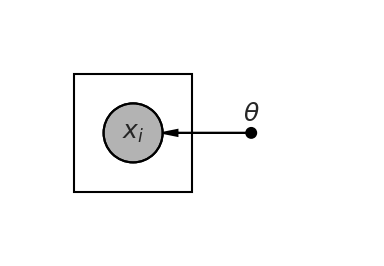

In [0]:
pgm = daft.PGM([3, 2])
pgm.add_node(daft.Node("x", "$x_i$", 1, 1, observed=True))
pgm.add_node(daft.Node("theta", r"$\theta$", 2, 1, fixed=True))
pgm.add_edge("theta", "x")
pgm.add_plate(daft.Plate([0.5, 0.5, 1, 1], ""))
pgm.render()
pgm.figure.dpi=150

In [0]:
def sample(theta):
    "Sample from p(x)."
    x = ds.Bernoulli(theta).sample()
    return x

In [0]:
obs = torch.tensor([0, 1, 1, 1.])
def mle(obs):
    "Estimate \theta."
    return obs.mean(0)

mle_predictive = ds.Bernoulli(mle(obs))

In [0]:
#@title Beta { run: "auto" }
a = 0.5 #@param {type:"slider", min:0, max:50, step:0.25}
b = 3.25 #@param {type:"slider", min:0, max:50, step:0.25}
x = torch.linspace(0, 1)
iplot(cs281.plot(x=x, y=ds.Beta(a, b).log_prob(x).exp()))

## Bayesian

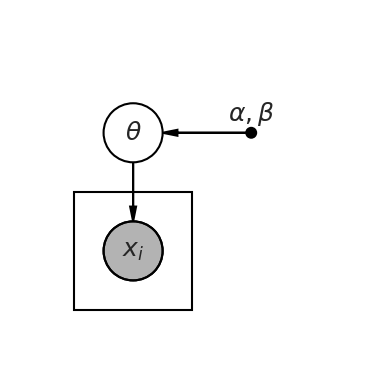

In [0]:
pgm = daft.PGM([3, 3])
pgm.add_node(daft.Node("x", "$x_i$", 1, 1, observed=True))
pgm.add_node(daft.Node("theta", r"$\theta$", 1, 2))
pgm.add_node(daft.Node("alpha", r"$\alpha,\beta$", 2, 2, fixed=True))
pgm.add_edge("theta", "x")
pgm.add_edge("alpha", "theta")
pgm.add_plate(daft.Plate([0.5, 0.5, 1, 1], ""))
pgm.render()
pgm.figure.dpi=150

In [0]:
def sample(alpha, beta, theta):
    "Sample from p(x)."
    theta = ds.Beta(alpha, beta).sample()
    x = ds.Bernoull(theta).sample()
    return x 

In [0]:
def posterior(alpha, beta, obs):
    "Compute p(\theta | \alpha, \beta, x)"
    N = obs.shape[0]
    N_1 = obs.sum()
    return ds.Beta(N_1 + alpha, N - N_1 + beta)

In [0]:
# Add a mode method.
ds.Beta.mode = lambda self: (self.concentration1 - 1) / (self.concentration0 + self.concentration1 - 2)

p = posterior(1, 1, obs)
map_predictive = ds.Bernoulli(p.mode())

In [0]:
# In this case, the posterior predictive is the same as using the mean (Murphy 3.3.4) 
posterior_predictive = ds.Bernoulli(p.mean)

## Visualization

In [0]:
alpha = torch.linspace(1e-10, 2, 10) 
beta = torch.linspace(1e-10, 2, 10)
z = [ [ posterior(a, b, obs).mean.item() for a in alpha] for b in beta]
z2 = [ [ posterior(a, b, obs).mode().item() for a in alpha] for b in beta]
z3 = [ [ mle(obs) for a in alpha] for b in beta]

surfaces = [go.Surface(z = z, x=alpha.numpy(), y=beta.numpy(),
                       name="Posterior Predictive", showscale=False),
            go.Surface(z = z2, x=alpha.numpy(), y=beta.numpy(),
                       name="MAP Predictive", showscale=False),
            go.Surface(z = z3, x=alpha.numpy(), y=beta.numpy(), 
                       name="MLE Predictive", showscale=False)]

layout = go.Layout(
    title='Predictive MAP vs Posterior',
    xaxis=dict(
        title='alpha',
    ),
    yaxis=dict(
        title='beta',
    )
)
fig = go.Figure(data=surfaces, layout=layout)
iplot(fig)

Shows density for z= Dir($\theta$; <$\alpha_1, \alpha_2, \alpha3$>)  in terms of x=$\theta_1$ and y=$\theta_2$ and implied $\theta_3 = (1 - \theta_1 -\theta_2)$

In [0]:
#@title Dirichlet { run: "auto" }

x_range = torch.linspace(0, 1, 50) 
y_range = torch.linspace(0, 1, 50)
zs = torch.tensor([ [ [x, y, 1-x-y] for x in x_range] for y in y_range])
def plot(d):
    z = d.log_prob(zs).exp()
    surfaces = [go.Surface(z = z.numpy(),  x=x_range.numpy(), y=y_range.numpy(),
                           name="Mass", showscale=False, colorscale="Reds")]
    layout = go.Layout(title='Dirichlet')
    fig = go.Figure(data=surfaces, layout=layout)
    iplot(fig)
alpha1 = 11 #@param {type:"slider", min:1, max:100, step:0.5}
alpha2 = 11 #@param {type:"slider", min:1, max:100, step:0.5}
alpha3 = 22 #@param {type:"slider", min:1, max:100, step:0.5}
plot(ds.Dirichlet(torch.tensor([alpha1, alpha2, alpha3]).float()))